# My project: open a restaurant in Amsterdam

# 1. Introduction

The purpose of this project is to help finding a top ten list of locations in Amsterdam with the lowest density of Italian Restaurants (i.e. locations where the competitors are most far away). 

I will help entrepreneurs who want to open an Italian restaurant in Amsterdam to make the best decision based on locations which are as far as possible from their competition.

I am italian living in the Netherlands, so this data analysis is very interesting for me. Italian restaurants are relatively cheap compared to other types of restaurants and they are suitable for all types of customers, therefore I will assume that the wealth of a certain neighborhood will not influence the chances of success of the restaurant. As a first analysis, I will consider the vicinity to another italian restaurant as the main cause of lower incomes generated.

Opening a restaurant in Amsterdam is a very attractive option. Amsterdam is a capital city with a huge amount of tourists all over the year.

The problem is that Amsterdam is also very pricy, rents can be sky high so the the investment can be also very risky due to the high costs of maintaining the restaurant. 

To make sure there is a return in the investment of opening a restaurant, I will study where opening a restaurant in Amsterdam is the most profitable due to the lowest amount of competitors in the vicinity.

# 2. Problem I try to solve

The major purpose of this project is to provide a list to a potential entrepreneur willing to open an italian restaurant in Amsterdam of areas where competitors would be most far away. 

# 3. Data

## Foursquare API

This project will use Four-square API as its prime data gathering source as it has a database of millions of places, especially their places API which provides the ability to perform location search, location sharing and details about a business. Using credentials of Foursquare API features of near-by places of the neighborhoods would be mined. 

## List of neighboroods in Amsterdam

As data I need a list of the neighboroods present in Amsterdam with: their postcode and possibly latitude and longitude (otherwise latitude and longitude can be generated from geocoder).

Multiple sites I can use for web scraping:
- https://postcode.site/noord-holland/amsterdam
- https://github.com/bobdenotter/4pp/blob/master/4pp.csv


# 4. Methodology

I will first look at the italian restaurants present in the different neighboroohds and then find the locations where there is a maximum distance to the nearest italian restaurant. The list of the top ten locations will be shared with the entrepreneur that can then evaluate where to open his/her restaurant also based on rents price for example.

## Libraries I will Use to Develop the Project:
Pandas: For creating and manipulating dataframes.
Folium: Python visualization library to visualize the neighborhoods cluster distribution of using interactive leaflet map.
Geocoder: To retrieve Location Data.
Beautiful Soup and Requests: To scrap and library to handle http requests.
Matplotlib: Python Plotting Module.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json, lxml
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# import folium # map rendering library
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings('ignore')

try:
    import folium
except:
    !pip install folium
    import folium

print('Libraries imported.')

Libraries imported.


# Start assembling the data needed

### I will first need to make a dataframe with the neighborhoods of Amsterdam

In [2]:
url2="https://raw.githubusercontent.com/francescarivello/4pp/master/4pp.csv"
postcodes=pd.read_csv(url2)
postcodes

,id,postcode,woonplaats,alternatieve_schrijfwijzen,gemeente,provincie,netnummer,latitude,longitude,soort
0,89,1100,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.376863,4.820028,Postbus
1,90,1101,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.308778,4.940660,Adres
2,91,1102,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.313517,4.954779,Adres
3,92,1103,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.323548,4.969858,Adres
4,93,1104,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.316447,4.980202,Adres
...,...,...,...,...,...,...,...,...,...,...
4694,4695,9995,Kantens,NaN,Eemsmond,Groningen,595,53.365440,6.633795,Adres
4695,4696,9996,Eppenhuizen,NaN,Eemsmond,Groningen,595,53.381294,6.696894,Adres
4696,4697,9997,Zandeweer,NaN,Eemsmond,Groningen,595,53.387513,6.681121,Adres
4697,4698,9998,Rottum,NaN,Eemsmond,Groningen,595,53.382942,6.620084,Adres


### Filter the data to keep only gemeente Amsterdam

In [3]:
Amsterdam_postcodes = postcodes[(postcodes.gemeente == "Amsterdam")]
Amsterdam_postcodes

,id,postcode,woonplaats,alternatieve_schrijfwijzen,gemeente,provincie,netnummer,latitude,longitude,soort
0,89,1100,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.376863,4.820028,Postbus
1,90,1101,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.308778,4.940660,Adres
2,91,1102,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.313517,4.954779,Adres
3,92,1103,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.323548,4.969858,Adres
4,93,1104,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.316447,4.980202,Adres
...,...,...,...,...,...,...,...,...,...,...
93,84,1095,Amsterdam,NaN,Amsterdam,Noord-Holland,20,52.361438,4.956728,Adres
94,85,1096,Amsterdam,NaN,Amsterdam,Noord-Holland,20,52.336341,4.919030,Adres
95,86,1097,Amsterdam,NaN,Amsterdam,Noord-Holland,20,52.346380,4.934099,Adres
96,87,1098,Amsterdam,NaN,Amsterdam,Noord-Holland,20,52.351124,4.948233,Adres


### Create a map of Amsterdam using the latitude and longitude value

In [4]:
address = 'Amsterdam'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Amsterdam are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Amsterdam are 52.3727598, 4.8936041.


In [5]:
map_Amsterdam = folium.Map(location=[latitude, longitude], zoom_start=11)

### Add markers to the map

In [6]:
for lat, lng, postcode, neighborhood in zip(Amsterdam_postcodes['latitude'], Amsterdam_postcodes['longitude'], Amsterdam_postcodes['postcode'], Amsterdam_postcodes['woonplaats']):
    label = '{}, {}'.format(neighborhood, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Amsterdam)  
    
map_Amsterdam

### Define foursquare credentials

In [7]:
CLIENT_ID = 'GRK15GTVZNKX4FWRIZ54YPZJVQKRKGMRX2X0BQPVXZAMNWPI' # your Foursquare ID
CLIENT_SECRET = 'IRAZNUJ5GN0HNYIUFHAXXAP0FLV243X32SPA5ZPEJK2EIRPO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GRK15GTVZNKX4FWRIZ54YPZJVQKRKGMRX2X0BQPVXZAMNWPI
CLIENT_SECRET:IRAZNUJ5GN0HNYIUFHAXXAP0FLV243X32SPA5ZPEJK2EIRPO


### Function that extracts the category of the venue

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:
Amsterdam_venues = getNearbyVenues(names=Amsterdam_postcodes['postcode'],
                                   latitudes=Amsterdam_postcodes['latitude'],
                                   longitudes=Amsterdam_postcodes['longitude']
                                  )

1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1000
1001
1002
1003
1005
1006
1007
1008
1009
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1030
1031
1032
1033
1034
1035
1036
1037
1040
1041
1042
1043
1044
1045
1046
1047
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1086
1087
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099


In [11]:
print(Amsterdam_venues.shape)
Amsterdam_venues.head()

(3271, 7)


,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1100,52.376863,4.820028,Şerifoğlu Gaziantep Baklavacısı,52.380708,4.820166,Dessert Shop
1,1100,52.376863,4.820028,Rondje Sloterplas 6 km,52.375380,4.820278,Park
2,1100,52.376863,4.820028,Şerifoğlu Café & Patisserie,52.380381,4.820672,Dessert Shop
3,1100,52.376863,4.820028,Meram West,52.380233,4.820814,Turkish Restaurant
4,1100,52.376863,4.820028,Albert Heijn,52.379813,4.823131,Supermarket


### Let's check the venues that are returned for each postcode

In [12]:
Amsterdam_venues.groupby('Postcode').count()

,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
1000,55,55,55,55,55,55
1001,74,74,74,74,74,74
1002,74,74,74,74,74,74
1003,74,74,74,74,74,74
1005,74,74,74,74,74,74
...,...,...,...,...,...,...
1105,5,5,5,5,5,5
1106,4,4,4,4,4,4
1107,5,5,5,5,5,5


In [13]:
Amsterdam_venues["Venue Category"]

0             Dessert Shop
1                     Park
2             Dessert Shop
3       Turkish Restaurant
4              Supermarket
               ...        
3266           Supermarket
3267           Coffee Shop
3268                 Hotel
3269        Soccer Stadium
3270         Metro Station
Name: Venue Category, Length: 3271, dtype: object

### Filter the venues based on restaurants to see where these are

In [14]:
Amsterdam_restaurants = Amsterdam_venues[(Amsterdam_venues["Venue Category"].str.contains("Restaurant"))]
Amsterdam_restaurants

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,1100,52.376863,4.820028,Meram West,52.380233,4.820814,Turkish Restaurant
9,1100,52.376863,4.820028,BeyMen Restaurant Café & Club,52.380567,4.821010,Turkish Restaurant
15,1100,52.376863,4.820028,De Rotonde kebab lunchroom,52.375487,4.820274,Fast Food Restaurant
17,1100,52.376863,4.820028,Döner Plaza,52.380821,4.821073,Turkish Restaurant
19,1100,52.376863,4.820028,Istanbul Steak House,52.380516,4.820875,Turkish Restaurant
...,...,...,...,...,...,...,...
3227,1096,52.336341,4.919030,Johnny River,52.333003,4.914632,Restaurant
3237,1096,52.336341,4.919030,Amstelle Restaurant,52.333368,4.914801,Restaurant
3243,1097,52.346380,4.934099,Wong Koen,52.348469,4.938521,Chinese Restaurant
3244,1097,52.346380,4.934099,'t Hoekje,52.349000,4.938355,Fast Food Restaurant


In [15]:
Amsterdam_restaurants.groupby('Postcode').count()

,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
1000,16,16,16,16,16,16
1001,9,9,9,9,9,9
1002,9,9,9,9,9,9
1003,9,9,9,9,9,9
1005,9,9,9,9,9,9
...,...,...,...,...,...,...
1100,5,5,5,5,5,5
1101,5,5,5,5,5,5
1102,14,14,14,14,14,14


### Filter the venues on italian restaurants

In [16]:
Amsterdam_italian_restaurants = Amsterdam_venues[(Amsterdam_venues["Venue Category"] == "Italian Restaurant")]
Amsterdam_italian_restaurants

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
47,1102,52.313517,4.954779,Pasta di Mamma,52.314779,4.955087,Italian Restaurant
59,1102,52.313517,4.954779,Ernos,52.314399,4.952724,Italian Restaurant
140,1000,52.336243,4.869444,Trattoria That's Amore @Market 33,52.337395,4.871206,Italian Restaurant
165,1000,52.336243,4.869444,Gustavino,52.337406,4.873579,Italian Restaurant
172,1000,52.336243,4.869444,Julia's,52.338120,4.873353,Italian Restaurant
...,...,...,...,...,...,...,...
3088,1092,52.358913,4.921387,Spaghetteria,52.354814,4.921788,Italian Restaurant
3090,1092,52.358913,4.921387,Restaurant Oost,52.359247,4.914358,Italian Restaurant
3143,1093,52.361286,4.928454,Gallizia,52.363849,4.934255,Italian Restaurant
3150,1094,52.363659,4.935523,La Fucina,52.363776,4.936060,Italian Restaurant


In [17]:
Amsterdam_italian_restaurants.groupby('Postcode').count()

,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
1000,3,3,3,3,3,3
1001,2,2,2,2,2,2
1002,2,2,2,2,2,2
1003,2,2,2,2,2,2
1005,2,2,2,2,2,2
1006,2,2,2,2,2,2
1007,2,2,2,2,2,2
1008,2,2,2,2,2,2
1009,2,2,2,2,2,2


In [18]:
map_Amsterdam3 = folium.Map(location=[latitude, longitude], zoom_start=12)

In [19]:
for lat, lng, venue, postcode in zip(Amsterdam_restaurants['Venue Latitude'], Amsterdam_restaurants['Venue Longitude'], Amsterdam_restaurants['Venue'], Amsterdam_restaurants['Postcode']):
    label = '{}, {}'.format(venue, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='black',
        fill=True,
        fill_color='#131a19',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Amsterdam3)  
    
map_Amsterdam3

### Show the italian restaurants on the Amsterdam map

### In black are shown all the restaurants and in red the italian restaurants

In [20]:
for lat, lng, venue, postcode in zip(Amsterdam_italian_restaurants['Venue Latitude'], Amsterdam_italian_restaurants['Venue Longitude'], Amsterdam_italian_restaurants['Venue'], Amsterdam_italian_restaurants['Postcode']):
    label = '{}, {}'.format(venue, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#e01616',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Amsterdam3)  
    
map_Amsterdam3

We can already see from the map that italian restaurants are mostly in the Centrum, West, Zuid and Oost. The Niew-West has some resaturants but only one italian and the Noord has no italian restaurant.

### Clusters all the postcodes in Amsterdam based on Venue type

In this way we can have an idea in which types of neighboroohods are italian restaurants

In [21]:
# one hot encoding
Amsterdam_onehot = pd.get_dummies(Amsterdam_venues[['Venue Category']], prefix="", prefix_sep="")
Amsterdam_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
Amsterdam_venues.head()

,Postcode,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1100,52.376863,4.820028,Şerifoğlu Gaziantep Baklavacısı,52.380708,4.820166,Dessert Shop
1,1100,52.376863,4.820028,Rondje Sloterplas 6 km,52.375380,4.820278,Park
2,1100,52.376863,4.820028,Şerifoğlu Café & Patisserie,52.380381,4.820672,Dessert Shop
3,1100,52.376863,4.820028,Meram West,52.380233,4.820814,Turkish Restaurant
4,1100,52.376863,4.820028,Albert Heijn,52.379813,4.823131,Supermarket


In [23]:
Amsterdam_onehot['Postcode'] = Amsterdam_venues['Postcode'] 

Amsterdam_onehot.head()

,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Postcode
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1100
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1100
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1100
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1100
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1100


In [24]:
Amsterdam_grouped = Amsterdam_onehot.groupby('Postcode').mean().reset_index()
Amsterdam_grouped

,Postcode,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Video Game Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,1000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040541,...,0.0,0.013514,0.0,0.013514,0.0,0.0,0.0,0.027027,0.0,0.0
2,1002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040541,...,0.0,0.013514,0.0,0.013514,0.0,0.0,0.0,0.027027,0.0,0.0
3,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040541,...,0.0,0.013514,0.0,0.013514,0.0,0.0,0.0,0.027027,0.0,0.0
4,1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040541,...,0.0,0.013514,0.0,0.013514,0.0,0.0,0.0,0.027027,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,1105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
92,1106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
93,1107,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
94,1108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0


### Run k-means with 5 clusters

In [25]:
# set number of clusters
kclusters = 5

Amsterdam_grouped_clustering = Amsterdam_grouped.drop('Postcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Amsterdam_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Postcode'] = Amsterdam_grouped['Postcode']

for ind in np.arange(Amsterdam_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Amsterdam_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1000,Coffee Shop,Italian Restaurant,Salad Place,Restaurant,Sushi Restaurant,Train Station,Café,Convenience Store,Japanese Restaurant,Breakfast Spot
1,1001,Hotel,Bar,Café,Restaurant,Music Venue,Art Gallery,Art Museum,Yoga Studio,Outdoor Supply Store,Italian Restaurant
2,1002,Hotel,Bar,Café,Restaurant,Music Venue,Art Gallery,Art Museum,Yoga Studio,Outdoor Supply Store,Italian Restaurant
3,1003,Hotel,Bar,Café,Restaurant,Music Venue,Art Gallery,Art Museum,Yoga Studio,Outdoor Supply Store,Italian Restaurant
4,1005,Hotel,Bar,Café,Restaurant,Music Venue,Art Gallery,Art Museum,Yoga Studio,Outdoor Supply Store,Italian Restaurant


In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [29]:
Amsterdam_postcodes.head()

,id,postcode,woonplaats,alternatieve_schrijfwijzen,gemeente,provincie,netnummer,latitude,longitude,soort
0,89,1100,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.376863,4.820028,Postbus
1,90,1101,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.308778,4.940660,Adres
2,91,1102,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.313517,4.954779,Adres
3,92,1103,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.323548,4.969858,Adres
4,93,1104,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.316447,4.980202,Adres


In [30]:
Amsterdam_merged = Amsterdam_postcodes

In [31]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Amsterdam_merged = Amsterdam_merged.join(neighborhoods_venues_sorted.set_index('Postcode'), on='postcode')

Amsterdam_merged

,id,postcode,woonplaats,alternatieve_schrijfwijzen,gemeente,provincie,netnummer,latitude,longitude,soort,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,89,1100,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.376863,4.820028,Postbus,...,Turkish Restaurant,Grocery Store,Discount Store,Supermarket,Dessert Shop,Clothing Store,Café,Drugstore,Furniture / Home Store,Snack Place
1,90,1101,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.308778,4.940660,Adres,...,Hotel,Restaurant,Playground,Coffee Shop,Soccer Stadium,Office,Electronics Store,Doner Restaurant,Scandinavian Restaurant,Bar
2,91,1102,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.313517,4.954779,Adres,...,Bakery,Clothing Store,Park,Chinese Restaurant,Sandwich Place,Plaza,Italian Restaurant,Fast Food Restaurant,Supermarket,Fruit & Vegetable Store
3,92,1103,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.323548,4.969858,Adres,...,Bus Stop,South American Restaurant,Chinese Restaurant,Grocery Store,Snack Place,Gym / Fitness Center,Turkish Restaurant,Drugstore,Supermarket,Farm
4,93,1104,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.316447,4.980202,Adres,...,Discount Store,Metro Station,Shopping Mall,Drugstore,Bakery,Food & Drink Shop,Supermarket,Fondue Restaurant,Flower Shop,Fish Market
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,84,1095,Amsterdam,NaN,Amsterdam,Noord-Holland,20,52.361438,4.956728,Adres,...,Harbor / Marina,Campground,Pool,Playground,Distillery,Farm,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit
94,85,1096,Amsterdam,NaN,Amsterdam,Noord-Holland,20,52.336341,4.919030,Adres,...,Hotel,Restaurant,Furniture / Home Store,Dance Studio,Sports Club,Bar,Hotel Bar,Cocktail Bar,Sandwich Place,Dutch Restaurant
95,86,1097,Amsterdam,NaN,Amsterdam,Noord-Holland,20,52.346380,4.934099,Adres,...,Drugstore,Museum,Fast Food Restaurant,Café,Chinese Restaurant,Cheese Shop,Plaza,Design Studio,Ethiopian Restaurant,Food Court
96,87,1098,Amsterdam,NaN,Amsterdam,Noord-Holland,20,52.351124,4.948233,Adres,...,Playground,Café,Convenience Store,Athletics & Sports,Farm,Soccer Field,Tennis Court,Train Station,Stadium,Dance Studio


### Visualize on the Amsterdam map the clusters of all the venues

In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

In [34]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [38]:
Amsterdam_merged_nona=Amsterdam_merged.dropna()

In [40]:
Amsterdam_merged_nona

,id,postcode,woonplaats,alternatieve_schrijfwijzen,gemeente,provincie,netnummer,latitude,longitude,soort,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,89,1100,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.376863,4.820028,Postbus,...,Turkish Restaurant,Grocery Store,Discount Store,Supermarket,Dessert Shop,Clothing Store,Café,Drugstore,Furniture / Home Store,Snack Place
1,90,1101,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.308778,4.940660,Adres,...,Hotel,Restaurant,Playground,Coffee Shop,Soccer Stadium,Office,Electronics Store,Doner Restaurant,Scandinavian Restaurant,Bar
2,91,1102,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.313517,4.954779,Adres,...,Bakery,Clothing Store,Park,Chinese Restaurant,Sandwich Place,Plaza,Italian Restaurant,Fast Food Restaurant,Supermarket,Fruit & Vegetable Store
3,92,1103,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.323548,4.969858,Adres,...,Bus Stop,South American Restaurant,Chinese Restaurant,Grocery Store,Snack Place,Gym / Fitness Center,Turkish Restaurant,Drugstore,Supermarket,Farm
4,93,1104,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.316447,4.980202,Adres,...,Discount Store,Metro Station,Shopping Mall,Drugstore,Bakery,Food & Drink Shop,Supermarket,Fondue Restaurant,Flower Shop,Fish Market
5,94,1105,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.292077,4.957572,Adres,...,Coffee Shop,Convenience Store,Café,Science Museum,Farm,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farmers Market
6,95,1106,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.300712,4.974051,Adres,...,Grocery Store,Park,Gas Station,Farm,Zoo Exhibit,Exhibit,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant
7,96,1107,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.291246,4.977324,Adres,...,IT Services,Chinese Restaurant,Snack Place,Pharmacy,Supermarket,Fondue Restaurant,Flower Shop,Fish Market,Fast Food Restaurant,Farmers Market
8,97,1108,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.306562,4.993361,Adres,...,Lake,Playground,Park,Zoo Exhibit,Farm,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
9,98,1109,Amsterdam-Zuidoost,Amsterdam Zuidoost,Amsterdam,Noord-Holland,20,52.311015,5.014093,Adres,...,Park,Skating Rink,Athletics & Sports,Soccer Field,Eastern European Restaurant,Empanada Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant


In [41]:
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Amsterdam_merged_nona['latitude'], Amsterdam_merged_nona['longitude'], Amsterdam_merged_nona['postcode'], Amsterdam_merged_nona['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Visualize the distribution of restaurants and italian restaurants per postcode

### General distribution of all the postcodes in Amsterdam

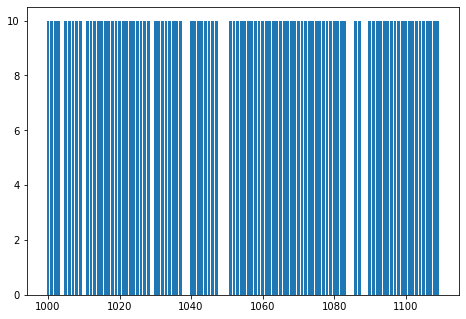

In [65]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
postcode = Amsterdam_postcodes['postcode']
venue = [10] * 98
ax.bar(postcode,venue)
plt.show()

### We see that there are some number missing as postcodes of Amsterdam, we have to pay attention to this fact before making conclusions

### Distribution of the Italian restaurants per barcode

In [56]:
Amsterdam_italian_restaurants_count=Amsterdam_italian_restaurants.groupby('Postcode').count()
Amsterdam_italian_restaurants_count.head()

,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
1000,3,3,3,3,3,3
1001,2,2,2,2,2,2
1002,2,2,2,2,2,2
1003,2,2,2,2,2,2
1005,2,2,2,2,2,2


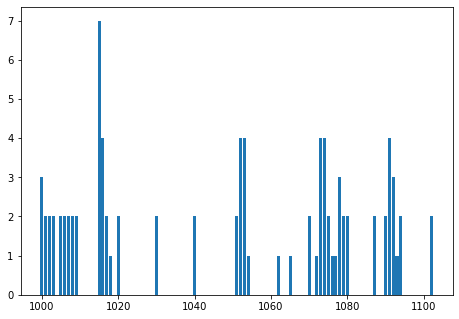

In [66]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
postcode = Amsterdam_italian_restaurants_count.index.values
venue = Amsterdam_italian_restaurants_count['Venue']
ax.bar(postcode,venue)
plt.show()

In [59]:
Amsterdam_italian_restaurants_count.index.values

array([1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1015, 1016,
       1017, 1018, 1020, 1030, 1040, 1051, 1052, 1053, 1054, 1062, 1065,
       1070, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079, 1080, 1087,
       1090, 1091, 1092, 1093, 1094, 1102])

### Visualization of the italian restaurants on the postcodes present in Amsterdam

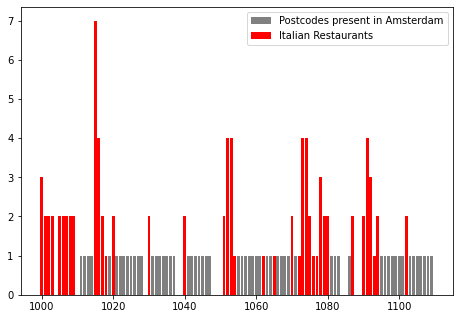

In [88]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
postcode = Amsterdam_postcodes['postcode']
venue = [1] * 98
ax.bar(postcode,venue, label='Postcodes present in Amsterdam', color='grey')
postcode_it = Amsterdam_italian_restaurants_count.index.values
venue_it = Amsterdam_italian_restaurants_count['Venue']
ax.bar(postcode_it,venue_it,label='Italian Restaurants', color='red')
plt.legend(loc='upper right')
plt.show()

From this plot it is clear that in the areas of Amsterdam with postcode between 1020 and 1050 there are very few (2) italian restaurants, as well as for postcodes higher than 1094.

### Let's see where are restaurants in general in Amsterdam (always visualizing their number per postcode)

In [83]:
Amsterdam_restaurants_count=Amsterdam_restaurants.groupby('Postcode').count()
Amsterdam_restaurants_count

,Postcode Latitude,Postcode Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Postcode,,,,,,
1000,16,16,16,16,16,16
1001,9,9,9,9,9,9
1002,9,9,9,9,9,9
1003,9,9,9,9,9,9
1005,9,9,9,9,9,9
...,...,...,...,...,...,...
1100,5,5,5,5,5,5
1101,5,5,5,5,5,5
1102,14,14,14,14,14,14


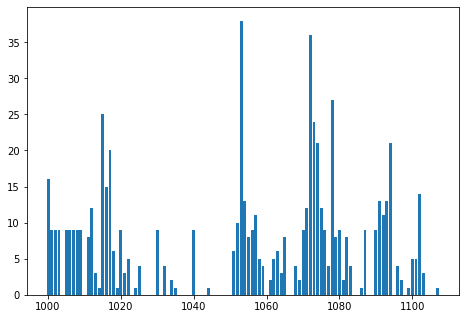

In [84]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
postcode = Amsterdam_restaurants_count.index.values
venue = Amsterdam_restaurants_count['Venue']
ax.bar(postcode,venue)
plt.show()

In [85]:
Amsterdam_restaurants_count.index.values

array([1000, 1001, 1002, 1003, 1005, 1006, 1007, 1008, 1009, 1011, 1012,
       1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022, 1024,
       1025, 1030, 1032, 1034, 1035, 1040, 1044, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1061, 1062, 1063, 1064, 1065, 1068,
       1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077, 1078, 1079,
       1080, 1081, 1082, 1083, 1086, 1087, 1090, 1091, 1092, 1093, 1094,
       1096, 1097, 1099, 1100, 1101, 1102, 1103, 1107])

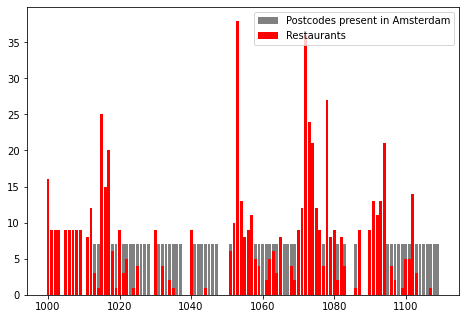

In [86]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
postcode = Amsterdam_postcodes['postcode']
venue = [7] * 98
ax.bar(postcode,venue, label='Postcodes present in Amsterdam', color='grey')
postcode_res = Amsterdam_restaurants_count.index.values
venue_res = Amsterdam_restaurants_count['Venue']
ax.bar(postcode_res,venue_res,label='Restaurants', color='red')
plt.legend(loc='upper right')
plt.show()

If we look at the distribution of restaurants in general this is also lower than average in areas of Amsterdam with postcode between 1020 and 1050. However, we see a peak of restaurants with postcodes around 1100. This could be then a good area to get started.

# 6. Discussion and conclusions

1. We visualized on the map of Amsterdam where all italian restaurants are and where are all types of restaurants are.
From that we could already see that that italian restaurants are mostly in the Centrum, West, Zuid and Oost. The Niew-West has some resaturants but only one italian and the Noord has no italian restaurant.

2. From the histograms it is clear that in the areas of Amsterdam with postcode between 1020 and 1050 there are very few (2) italian restaurants, as well as for postcodes higher than 1094.

3. If we look at the distribution of restaurants in general this is also lower than average in areas of Amsterdam with postcode between 1020 and 1050. However, we see a peak of restaurants with postcodes around 1100. This could be then a good area to get started.

### Areas of Amsterdam with postcodes around 1100 could be a got locations to get an Italian reastaurant started due to :
1. the scarcity of other italian restaurants
2. the presence of other restaurants which still mean that the area is attractive and most probably in expansion